## Trigger Word Detection

Here we will apply deep learning to speech recognition. We will construct a speech dataset and implement an algorithm for trigger word detection (sometimes also called keyword detection, or wake word detection). 

* Trigger word detection is the technology that allows devices like Amazon Alexa, Google Home, Apple Siri, and Baidu DuerOS to wake up upon hearing a certain word.  
* For this exercise, our trigger word will be "activate". Every time it hears you say "activate", it will make a "chiming" sound. 
* By the end of this assignment, you will be able to record a clip of yourself talking, and have the algorithm trigger a chime when it detects you saying "activate". 
* After completing this assignment, perhaps you can also extend it to run on your laptop so that every time you say "activate" it starts up your favorite app, or turns on a network connected lamp in your house, or triggers some other event? 

<img src="images/sound.png" style="width:1000px;height:150px;">

Objectives: 
- Structure a speech recognition project
- Synthesize and process audio recordings to create train/dev datasets
- Train a trigger word detection model and make predictions


In [1]:
!pip install pydub

In [2]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from scipy.io import wavfile


%matplotlib inline

<a name='1'></a>
## 1 - Data synthesis: Creating a Speech Dataset 

Building a dataset for your trigger word detection algorithm. 
* A speech dataset should ideally be as close as possible to the application you will want to run it on. 
* In this case, you'd like to detect the word "activate" in working environments (library, home, offices, open-spaces ...). 
* Therefore, you need to create recordings with a mix of positive words ("activate") and negative words (random words other than activate) on different background sounds. Let's see how you can create such a dataset. 

<a name='1-1'></a>
### 1.1 - Listening to the Data   

* One of your friends is helping you out on this project, and they've gone to libraries, cafes, restaurants, homes and offices all around the region to record background noises, as well as snippets of audio of people saying positive/negative words. This dataset includes people speaking in a variety of accents. 
* In the raw_data directory, you can find a subset of the raw audio files of the positive words, negative words, and background noise. You will use these audio files to synthesize a dataset to train the model. 
    * The "activate" directory contains positive examples of people saying the word "activate". 
    * The "negatives" directory contains negative examples of people saying random words other than "activate". 
    * There is one word per audio recording. 
    * The "backgrounds" directory contains 10 second clips of background noise in different environments.

Run the cells below to listen to some examples.

In [ ]:
IPython.display.Audio("./raw_data/activates/1_act3.wav")

In [ ]:
IPython.display.Audio("./raw_data/negatives/2_1.wav")

In [ ]:
IPython.display.Audio("./raw_data/backgrounds/1.wav")

We will use these three types of recordings (positives/negatives/backgrounds) to create a labeled dataset.

<a name='1-2'></a>
### 1.2 - From Audio Recordings to Spectrograms

What really is an audio recording? 
* A microphone records little variations in air pressure over time, and it is these little variations in air pressure that your ear also perceives as sound. 
* You can think of an audio recording as a long list of numbers measuring the little air pressure changes detected by the microphone. 
* We will use audio sampled at 44100 Hz (or 44100 Hertz). 
    * This means the microphone gives us 44,100 numbers per second. 
    * Thus, a 10 second audio clip is represented by 441,000 numbers (= $10 \times 44,100$). 

#### Spectrogram
* It is quite difficult to figure out from this "raw" representation of audio whether the word "activate" was said. 
* In  order to help your sequence model more easily learn to detect trigger words, we will compute a *spectrogram* of the audio. 
* The spectrogram tells us how much different frequencies are present in an audio clip at any moment in time. 
* If you've ever taken an advanced class on signal processing or on Fourier transforms:
    * A spectrogram is computed by sliding a window over the raw audio signal, and calculating the most active frequencies in each window using a Fourier transform. 

Let's look at an example. 

In [ ]:
IPython.display.Audio("audio_examples/example_train.wav")

In [7]:
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
        
    return pxx #pxx is spectrum

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data


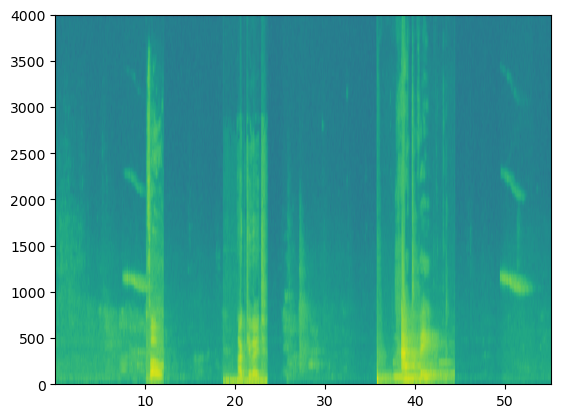

In [8]:
x = graph_spectrogram("audio_examples/example_train.wav")

The graph above represents how active each frequency is (y axis) over a number of time-steps (x axis). 

<img src="images/spectrogram.png" style="width:500px;height:200px;">
<center> **Figure 1**: Spectrogram of an audio recording </center>


* The color in the spectrogram shows the degree to which different frequencies are present (loud) in the audio at different points in time. 
* Green means a certain frequency is more active or more present in the audio clip (louder).
* Blue squares denote less active frequencies.
* The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. 
* In this notebook, we will be working with 10 second audio clips as the "standard length" for our training examples. 
    * The number of timesteps of the spectrogram will be 5511. 
    * You'll see later that the spectrogram will be the input $x$ into the network, and so $T_x = 5511$.

In [9]:
_, data = wavfile.read("audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [10]:
Tx = x.shape[1]       # i.e 5511 - The number of time steps input to the model from the spectrogram
n_freq = x.shape[0]   # i.e 101 -  Number of frequencies input to the model at each time step of the spectrogram

#### Dividing into time-intervals
Note that we may divide a 10 second interval of time with different units (steps).
* Raw audio divides 10 seconds into 441,000 units.
* A spectrogram divides 10 seconds into 5,511 units.
    * $T_x = 5511$
* You will use a Python module `pydub` to synthesize audio, and it divides 10 seconds into 10,000 units.
* The output of our model will divide 10 seconds into 1,375 units.
    * $T_y = 1375$
    * For each of the 1375 time steps, the model predicts whether someone recently finished saying the trigger word "activate". 
* All of these are hyperparameters and can be changed (except the 441000, which is a function of the microphone). 
* We have chosen values that are within the standard range used for speech systems.

In [11]:
Ty = 1375 # The number of time steps in the output of our model

In [12]:
# Load raw audio files for speech synthesis
def load_raw_audio(path):
    activates=[]
    negatives=[]
    backgrounds=[]
    
    #Load all activate clips
    for filename in os.listdir(path+'activates'):
        if filename.endswith('wav'):
            activate=AudioSegment.from_wav(path+'activates/'+filename)
            activates.append(activate)
            
    #Load all negative clips
    for filename in os.listdir(path+'negatives'):
        if filename.endswith('wav'):
            negative=AudioSegment.from_wav(path+'negatives/'+filename)
            negatives.append(negative)
            
    #Load all backgrounds clips
    for filename in os.listdir(path+'backgrounds'):
        if filename.endswith('wav'):
            background=AudioSegment.from_wav(path+'backgrounds/'+filename)
            backgrounds.append(background)
    
    return activates,negatives,backgrounds

In [13]:
activates, negatives, backgrounds = load_raw_audio('./raw_data/')


print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
725 

activate[1] len: different `activate` clips can have different lengths
916 



#### Overlaying positive/negative 'word' audio clips on top of the background audio

* Given a 10 second background clip and a short audio clip containing a positive or negative word, you need to be able to "add" the word audio clip on top of the background audio.
* You will be inserting multiple clips of positive/negative words into the background, and you don't want to insert an "activate" or a random word somewhere that overlaps with another clip you had previously added. 
    * To ensure that the 'word' audio segments do not overlap when inserted, you will keep track of the times of previously inserted audio clips. 
* To be clear, when you insert a 1 second "activate" onto a 10 second clip of cafe noise, **you do not end up with an 11 sec clip.** 
    * The resulting audio clip is still 10 seconds long.
    * You'll see later how pydub allows you to do this. 

#### Label the positive/negative words
* Recall that the labels $y^{\langle t \rangle}$ represent whether or not someone has just finished saying "activate". 
    * $y^{\langle t \rangle} = 1$ when that clip has finished saying "activate".
    * Given a background clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any "activate". 
* When you insert or overlay an "activate" clip, you will also update labels for $y^{\langle t \rangle}$.
    * Rather than updating the label of a single time step, we will update 50 steps of the output to have target label 1. 
    * Recall from the lecture on trigger word detection that updating several consecutive time steps can make the training data more balanced.
* You will train a GRU (Gated Recurrent Unit) to detect when someone has **finished** saying "activate". 

##### Example
* Suppose the synthesized "activate" clip ends at the 5 second mark in the 10 second audio - exactly halfway into the clip. 
* Recall that $T_y = 1375$, so timestep $687 = $ `int(1375*0.5)` corresponds to the moment 5 seconds into the audio clip. 
* Set $y^{\langle 688 \rangle} = 1$. 
* We will allow the GRU to detect "activate" anywhere within a short time-internal **after** this moment, so we actually **set 50 consecutive values** of the label $y^{\langle t \rangle}$ to 1. 
    * Specifically, we have $y^{\langle 688 \rangle} = y^{\langle 689 \rangle} = \cdots = y^{\langle 737 \rangle} = 1$.  

##### Synthesized data is easier to label
* This is another reason for synthesizing the training data: It's relatively straightforward to generate these labels $y^{\langle t \rangle}$ as described above. 
* In contrast, if you have 10sec of audio recorded on a microphone, it's quite time consuming for a person to listen to it and mark manually exactly when "activate" finished. 

#### Visualizing the labels
* Here's a figure illustrating the labels $y^{\langle t \rangle}$ in a clip.
    * We have inserted "activate", "innocent", "activate", "baby." 
    * Note that the positive labels "1" are associated only with the positive words. 

<img src="images/label_diagram.png" style="width:500px;height:200px;">
<center> **Figure 2** </center>



#### Helper functions

To implement the training set synthesis process, you will use the following helper functions. 
* All of these functions will use a 1ms discretization interval
* The 10 seconds of audio is always discretized into 10,000 steps. 


1. `get_random_time_segment(segment_ms)`
    * Retrieves a random time segment from the background audio.
2. `is_overlapping(segment_time, existing_segments)`
    * Checks if a time segment overlaps with existing segments
3. `insert_audio_clip(background, audio_clip, existing_times)`
    * Inserts an audio segment at a random time in the background audio
    * Uses the functions `get_random_time_segment` and `is_overlapping`
4. `insert_ones(y, segment_end_ms)`
    * Inserts additional 1's into the label vector y after the word "activate"

#### Get a random time segment

* The function `get_random_time_segment(segment_ms)` returns a random time segment onto which we can insert an audio clip of duration `segment_ms`. 


In [14]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start=np.random.randint(low=0,high=10000-segment_ms)
    segment_end=segment_start+segment_ms-1
    return (segment_start,segment_end)

#### Check if audio clips are overlapping

* Suppose you have inserted audio clips at segments (1000,1800) and (3400,4500).
    * The first segment starts at step 1000 and ends at step 1800. 
    * The second segment starts at 3400 and ends at 4500.
* If we are considering whether to insert a new audio clip at (3000,3600) does this overlap with one of the previously inserted segments? 
    * In this case, (3000,3600) and (3400,4500) overlap, so we should decide against inserting a clip here.
* For the purpose of this function, define (100,200) and (200,250) to be overlapping, since they overlap at timestep 200. 
* (100,199) and (200,250) are non-overlapping. 

<a name='ex-1'></a>
### Implement  is_overlapping

* Implement `is_overlapping(segment_time, existing_segments)` to check if a new time segment overlaps with any of the previous segments. 
* You will need to carry out 2 steps:

1. Create a "False" flag, that you will later set to "True" if you find that there is an overlap.
2. Loop over the previous_segments' start and end times. Compare these times to the segment's start and end times. If there is an overlap, set the flag defined in (1) as True. 


Hint: There is overlap if:
* The new segment starts before the previous segment ends **and**
* The new segment ends after the previous segment starts.

In [15]:

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start,segment_end=segment_time
    
    overlap=False
    
    for previous_start,previous_end in previous_segments:
        if segment_start<=previous_end and segment_end>=previous_start:
            overlap = True
            break
    
    return overlap

In [16]:
#Example
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


#### Insert audio clip

* Let's use the previous helper functions to insert a new audio clip onto the 10 second background at a random time.
* We will ensure that any newly inserted segment doesn't overlap with previously inserted segments. 

<a name='ex-2'></a>
### Implement insert_audio_clip
* Implement `insert_audio_clip()` to overlay an audio clip onto the background 10sec clip. 
* You implement 4 steps:

1. Get the length of the audio clip that is to be inserted.
    * Get a random time segment whose duration equals the duration of the audio clip that is to be inserted.
2. Make sure that the time segment does not overlap with any of the previous time segments. 
    * If it is overlapping, then go back to step 1 and pick a new time segment.
3. Append the new time segment to the list of existing time segments
    * This keeps track of all the segments you've inserted.  
4. Overlay the audio clip over the background using pydub. We have implemented this for you.

In [17]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    segment_time   -- start and end time of inserted audio clip 
    """
    segment_ms=len(audio_clip)
    segment_time=get_random_time_segment(segment_ms)
    
    retry=5
    while is_overlapping(segment_time, previous_segments) and retry >=0:
        segment_time=get_random_time_segment(segment_ms)
        retry-=1
    
    if not is_overlapping(segment_time, previous_segments):
        previous_segments.append(segment_time)
        new_background=background.overlay(audio_clip,position=segment_time[0])
        #print(segment_time)
    else:
        #print("Timed Out")
        new_background=background
        segment_time=(10000,10000)
    
    return new_background,segment_time

#### Insert ones for the labels of the positive target

* Implement code to update the labels $y^{\langle t \rangle}$, assuming you just inserted an "activate" audio clip.
* In the code below, `y` is a `(1,1375)` dimensional vector, since $T_y = 1375$. 
* If the "activate" audio clip ends at time step $t$, then set $y^{\langle t+1 \rangle} = 1$ and also set the next 49 additional consecutive values to 1.
    * Notice that if the target word appears near the end of the entire audio clip, there may not be 50 additional time steps to set to 1.
    * Make sure you don't run off the end of the array and try to update `y[0][1375]`, since the valid indices are `y[0][0]` through `y[0][1374]` because $T_y = 1375$. 
    * So if "activate" ends at step 1370, you would get only set `y[0][1371] = y[0][1372] = y[0][1373] = y[0][1374] = 1`

<a name='ex-3'></a>
#### Implement `insert_ones()`. 
* You can use a for loop. 
* If you want to use Python's array slicing operations, you can do so as well.
* If a segment ends at `segment_end_ms` (using a 10000 step discretization),
    * To convert it to the indexing for the outputs $y$ (using a $1375$ step discretization), we will use this formula:  
```
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
```

In [18]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    _,Ty=y.shape
    
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:
        if segment_end_y+51 < Ty:
            y[0,segment_end_y+1:segment_end_y+51]=1
        else:
            y[0,segment_end_y+1:]=1
    
    return y

sanity checks: 0.0 1.0 0.0


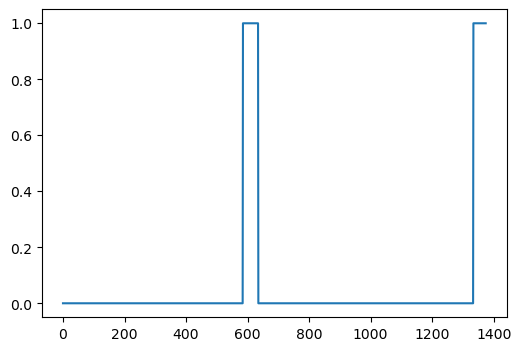

In [19]:
plt.figure(figsize=(6,4))

arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

#### Creating a training example
Finally, you can use `insert_audio_clip` and `insert_ones` to create a new training example.

<a name='ex-4'></a>

#### Implement `create_training_example()` 
We will need to carry out the following steps:

1. Initialize the label vector $y$ as a numpy array of zeros and shape $(1, T_y)$.
2. Initialize the set of existing segments to an empty list.
3. Randomly select 0 to 4 "activate" audio clips, and insert them onto the 10 second clip. Also insert labels at the correct position in the label vector $y$.
4. Randomly select 0 to 2 negative audio clips, and insert them into the 10 second clip. 


In [20]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

In [21]:
def create_training_example(background, activates, negatives, Ty):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    background=background-20
    
    y=np.zeros((1,Ty))
    previous_segments=[]
    
    #randomly choose 0 to 4 activates
    no_of_activates=np.random.randint(0,5)
    indices_of_activates=np.random.randint(len(activates),size=no_of_activates)
    random_activates=[activates[i] for i in indices_of_activates]
    
    #insert selected activates on background
    for random_activate in random_activates:
        background,segment_time = insert_audio_clip(background,random_activate,previous_segments)
        segment_start,segment_end =segment_time
        y=insert_ones(y,segment_end)
        previous_segments.append(segment_time)
    
    #randomly choose 0 to 2 negatives
    no_of_negatives=np.random.randint(0,3)
    indices_of_negatives=np.random.randint(len(negatives),size=no_of_negatives)
    random_negatives=[negatives[i] for i in indices_of_negatives]
    
    #insert selected negatives on background
    for random_negative in random_negatives:
        background,_ = insert_audio_clip(background,random_negative,previous_segments)
   
    background=match_target_amplitude(background,-20.0)
    
    #save in wav format
    file_handle=background.export("train.wav",format='wav')
    
    x=graph_spectrogram("train.wav")
    
    return x,y

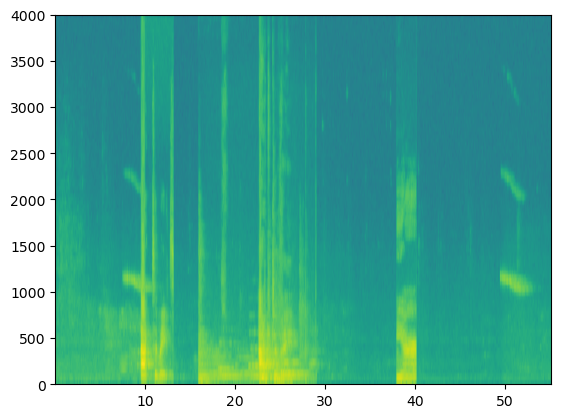

In [22]:
# Set the random seed
np.random.seed(18)
x, y = create_training_example(backgrounds[0], activates, negatives, Ty)

In [ ]:
IPython.display.Audio("train.wav")

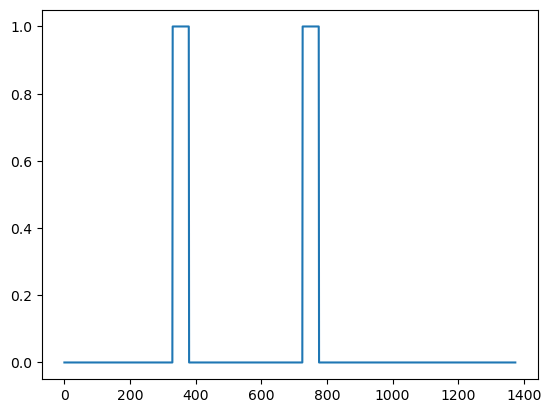

In [24]:
plt.plot(y[0])

In [25]:
x.shape,y.shape

((101, 5511), (1, 1375))

<a name='1-4'></a>
### 1.4 - Full Training Set

* You've now implemented the code needed to generate a single training example. 
* We used this process to generate a large training set. 
* To save time, we generate a smaller training set of 32 examples. 

0
10
20
30


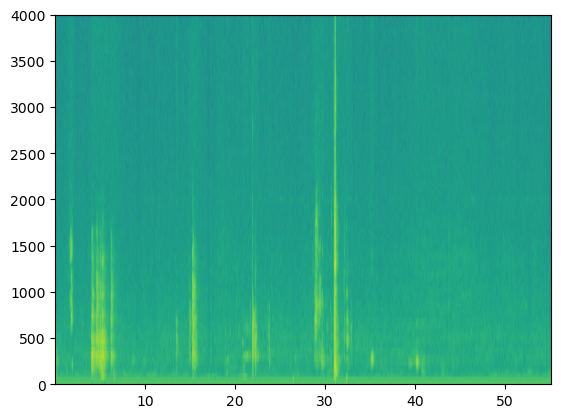

In [26]:
np.random.seed(4543)
nsamples = 32
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

In [27]:
X.shape,Y.shape

((32, 5511, 101), (32, 1375, 1))

<a name='1-5'></a>
### 1.5 - Development Set

* To test our model, we recorded a development set of 25 examples. 
* While our training data is synthesized, we want to create a development set using the same distribution as the real inputs. 
* Thus, we recorded 25 10-second audio clips of people saying "activate" and other random words, and labeled them by hand. 
* This follows the principle described in Course 3 "Structuring Machine Learning Projects" that we should create the dev set to be as similar as possible to the test set distribution
    * This is why our **dev set uses real audio** rather than synthesized audio. 


In [28]:
# Load preprocessed dev set examples
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")

In [29]:
X_dev.shape,Y_dev.shape

((25, 5511, 101), (25, 1375, 1))

<a name='2'></a>
## 2 - The Model

* Now that you've built a dataset, let's write and train a trigger word detection model! 
* The model will use 1-D convolutional layers, GRU layers, and dense layers. 
* Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

<a name='2-1'></a>
### 2.1 - Build the Model

Our goal is to build a network that will ingest a spectrogram and output a signal when it detects the trigger word. This network will use 4 layers:
    * A convolutional layer
    * Two GRU layers
    * A dense layer. 

Here is the architecture we will use.

<img src="images/model.png" style="width:600px;height:600px;">
<center> **Figure 3** </center>

##### 1D convolutional layer
One key layer of this model is the 1D convolutional step (near the bottom of Figure 3). 
* It inputs the 5511 step spectrogram.  Each step is a vector of 101 units.
* It outputs a 1375 step output
* This output is further processed by multiple layers to get the final $T_y = 1375$ step output. 
* This 1D convolutional layer plays a role similar to the 2D convolutions you saw in Course 4, of extracting low-level features and then possibly generating an output of a smaller dimension. 
* Computationally, the 1-D conv layer also helps speed up the model because now the GRU  can process only 1375 timesteps rather than 5511 timesteps. 

##### GRU, dense and sigmoid
* The two GRU layers read the sequence of inputs from left to right.
* A dense plus sigmoid layer makes a prediction for $y^{\langle t \rangle}$. 
* Because $y$ is a binary value (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the user having just said "activate".

#### Unidirectional RNN
* Note that we use a **unidirectional RNN** rather than a bidirectional RNN. 
* This is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said. 
* If we used a bidirectional RNN, we would have to wait for the whole 10sec of audio to be recorded before we could tell if "activate" was said in the first second of the audio clip.  

Last layer will be a time-distributed dense layer as follows: 
```Python
output_x = TimeDistributed(Dense(1, activation = "sigmoid"))(input_x)
```
This creates a dense layer followed by a sigmoid, so that the parameters used for the dense layer are the same for every time step.  

In [31]:
def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    x_inputs=Input(shape=(input_shape))
    
    #Conv1D Layer
    x=Conv1D(196,15,strides=4)(x_inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.8)(x)
    
    #1st Gru layer
    x=GRU(128,return_sequences=True)(x)
    x=Dropout(0.8)(x)
    x=BatchNormalization()(x)
    
    #2nd Gru layer
    x=GRU(128,return_sequences=True)(x)
    x=Dropout(0.8)(x)
    x=BatchNormalization()(x)
    x=Dropout(0.8)(x)
    
    #Last Layer
    x=TimeDistributed(Dense(1,activation='sigmoid'))(x)
    
    model=Model(inputs=x_inputs,outputs=x)
    
    return model

In [ ]:
model=modelf(input_shape=(Tx,n_freq))

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5511, 101)]       0         
                                                                 
 conv1d (Conv1D)             (None, 1375, 196)         297136    
                                                                 
 batch_normalization (BatchN  (None, 1375, 196)        784       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1375, 196)         0         
                                                                 
 dropout (Dropout)           (None, 1375, 196)         0         
                                                                 
 gru (GRU)                   (None, 1375, 128)         125184    
                                                             

In [34]:
opt = Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [35]:
model.fit(X, Y, batch_size = 16, epochs=10)

Epoch 1/10
2/2 [==============================] - 8s 2s/step - loss: 1.3209 - accuracy: 0.4992
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 1.3223 - accuracy: 0.4955
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 1.3287 - accuracy: 0.4996
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 1.3225 - accuracy: 0.4965
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 1.3230 - accuracy: 0.5002
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 1.3093 - accuracy: 0.4981
Epoch 7/10
2/2 [==============================] - 4s 2s/step - loss: 1.3226 - accuracy: 0.4968
Epoch 8/10
2/2 [==============================] - 4s 2s/step - loss: 1.3182 - accuracy: 0.5026
Epoch 9/10
2/2 [==============================] - 4s 2s/step - loss: 1.3163 - accuracy: 0.5010
Epoch 10/10
2/2 [==============================] - 4s 2s/step - loss: 1.3229 - accuracy: 0.4942


**For better performance train more examples with more epochs**

<a name='2-3'></a>
### 2.3 - Test the Model

Finally, let's see how your model performs on the dev set.

In [36]:
loss, acc, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

1/1 [==============================] - 2s 2s/step - loss: 0.6776 - accuracy: 0.9104
Dev set accuracy =  0.9103999733924866


<a name='3'></a>
## 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

<!--
can use your model to make predictions on new audio clips.

You will first need to compute the predictions for an input audio clip.

**Exercise**: Implement predict_activates(). You will need to do the following:

1. Compute the spectrogram for the audio file
2. Use `np.swap` and `np.expand_dims` to reshape your input to size (1, Tx, n_freqs)
5. Use forward propagation on your model to compute the prediction at each output step
!-->

In [37]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    
    # Correct the amplitude of the input file before prediction 
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    file_handle = audio_clip.export("tmp.wav", format="wav")
    filename = "tmp.wav"

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

#### Insert a chime to acknowledge the "activate" trigger
* Once you've estimated the probability of having detected the word "activate" at each output step, you can trigger a "chiming" sound to play when the probability is above a certain threshold. 
* $y^{\langle t \rangle}$ might be near 1 for many values in a row after "activate" is said, yet we want to chime only once. 
    * So we will insert a chime sound at most once every 75 output steps. 
    * This will help prevent us from inserting two chimes for a single instance of "activate". 
    * This plays a role similar to non-max suppression from computer vision.

<!-- 
**Exercise**: Implement chime_on_activate(). You will need to do the following:

1. Loop over the predicted probabilities at each output step
2. When the prediction is larger than the threshold and more than 75 consecutive time steps have passed, insert a "chime" sound onto the original audio clip

Use this code to convert from the 1,375 step discretization to the 10,000 step discretization and insert a "chime" using pydub:

` audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio.duration_seconds)*1000)
`
!--> 

In [39]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 20 consecutive output steps have passed
        if consecutive_timesteps > 20:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds) * 1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        # if amplitude is smaller than the threshold reset the consecutive_timesteps counter
        if predictions[0, i, 0] < threshold:
            consecutive_timesteps = 0
        
    audio_clip.export("applied_chime_output.wav", format='wav')

<a name='3-1'></a>
### 3.1 - Test on Dev Examples

In [ ]:
IPython.display.Audio("./raw_data/dev/2.wav")

In [ ]:
filename  = "./raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./applied_chime_output.wav")